In [2]:
!pip install tensorflow


   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/332.0 MB 3.3 MB/s eta 0:01:42
   ---------------------------------------- 1.6/332.0 MB 3.9 MB/s eta 0:01:24
   ---------------------------------------- 2.6/332.0 MB 4.1 MB/s eta 0:01:22
   ---------------------------------------- 3.9/332.0 MB 4.7 MB/s eta 0:01:10
    --------------------------------------- 4.2/332.0 MB 4.7 MB/s eta 0:01:11
    --------------------------------------- 4.5/332.0 MB 3.5 MB/s eta 0:01:35
    --------------------------------------- 5.2/332.0 MB 3.5 MB/s eta 0:01:34
    --------------------------------------- 6.0/332.0 MB 3.6 MB/s eta 0:01:32
    --------------------------------------- 6.6/332.0 MB 3.5 MB/s eta 0:01:34
    --------------------------------------- 7.1/332.0 MB 3.3 MB/s eta 0:01:38
    --------------------------------------- 7.3/332.0 MB 3.4 MB/s eta 0:01:37
    --------------------------------------- 8.1/332.0 MB 3.2 MB/s eta 0

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, recall_score

from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [4]:
df = pd.read_csv("Home_loan_data.csv")
df.head()


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df.shape, df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


((307511, 122), None)

In [6]:
df.isnull().sum()


SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64

In [7]:
# Fill numerical columns with median
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill categorical columns with mode
cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])


In [8]:
default_counts = df['TARGET'].value_counts()
default_percentage = default_counts / len(df) * 100
default_percentage


TARGET
0    91.927118
1     8.072882
Name: count, dtype: float64

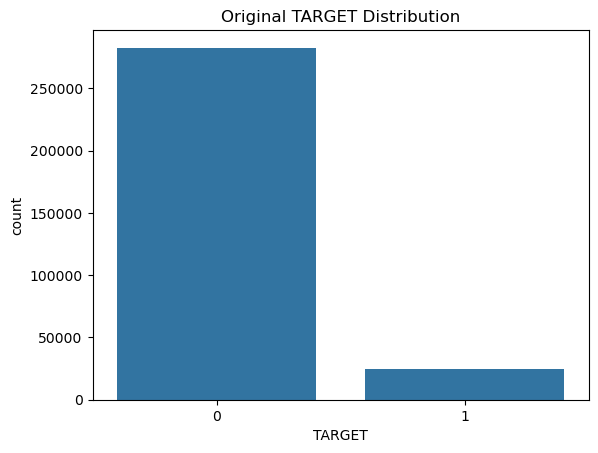

In [9]:
sns.countplot(x='TARGET', data=df)
plt.title("Original TARGET Distribution")
plt.show()


In [10]:
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])


In [11]:
X = df.drop('TARGET', axis=1)
y = df['TARGET']


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [14]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


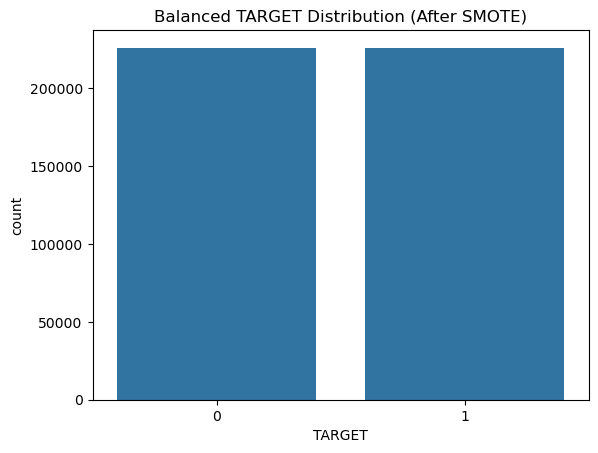

In [15]:
sns.countplot(x=y_train_res)
plt.title("Balanced TARGET Distribution (After SMOTE)")
plt.show()


In [16]:
model = Sequential()

model.add(Dense(128, activation='relu', input_shape=(X_train_res.shape[1],)))
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


c:\Users\rhtgh\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,985 (101.50 KB)

 Trainable params: 25,985 (101.50 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_res, y_train_res,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
11308/11308 ━━━━━━━━━━━━━━━━━━━━ 59s 5ms/step - accuracy: 0.7248 - loss: 0.5409 - val_accuracy: 0.5725 - val_loss: 0.7116
Epoch 2/50
11308/11308 ━━━━━━━━━━━━━━━━━━━━ 65s 6ms/step - accuracy: 0.7532 - loss: 0.5053 - val_accuracy: 0.6899 - val_loss: 0.5750
Epoch 3/50
11308/11308 ━━━━━━━━━━━━━━━━━━━━ 57s 5ms/step - accuracy: 0.7648 - loss: 0.4888 - val_accuracy: 0.7032 - val_loss: 0.5611
Epoch 4/50
11308/11308 ━━━━━━━━━━━━━━━━━━━━ 57s 5ms/step - accuracy: 0.7725 - loss: 0.4780 - val_accuracy: 0.7234 - val_loss: 0.5390
Epoch 5/50
11308/11308 ━━━━━━━━━━━━━━━━━━━━ 67s 6ms/step - accuracy: 0.7773 - loss: 0.4696 - val_accuracy: 0.7251 - val_loss: 0.5420
Epoch 6/50
11308/11308 ━━━━━━━━━━━━━━━━━━━━ 58s 5ms/step - accuracy: 0.7821 - loss: 0.4631 - val_accuracy: 0.7647 - val_loss: 0.4743
Epoch 7/50
11308/11308 ━━━━━━━━━━━━━━━━━━━━ 57s 5ms/step - accuracy: 0.7844 - loss: 0.4585 - val_accuracy: 0.7699 - val_loss: 0.4658
Epoch 8/50
11308/11308 ━━━━━━━━━━━━━━━━━━━━ 64s 6ms/step - accuracy: 

In [18]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


1922/1922 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
[[48330  8208]
 [ 3059  1906]]
              precision    recall  f1-score   support

           0       0.94      0.85      0.90     56538
           1       0.19      0.38      0.25      4965

    accuracy                           0.82     61503
   macro avg       0.56      0.62      0.57     61503
weighted avg       0.88      0.82      0.84     61503



In [19]:
sensitivity = recall_score(y_test, y_pred)
print("Sensitivity (Recall):", sensitivity)


Sensitivity (Recall): 0.3838872104733132


In [20]:
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC Score:", roc_auc)


ROC-AUC Score: 0.709189876555322


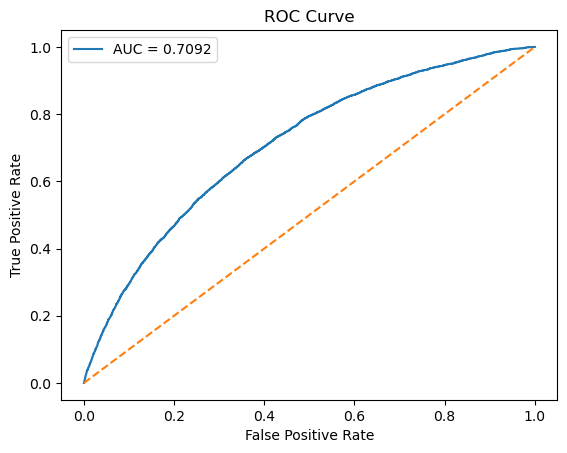

In [21]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


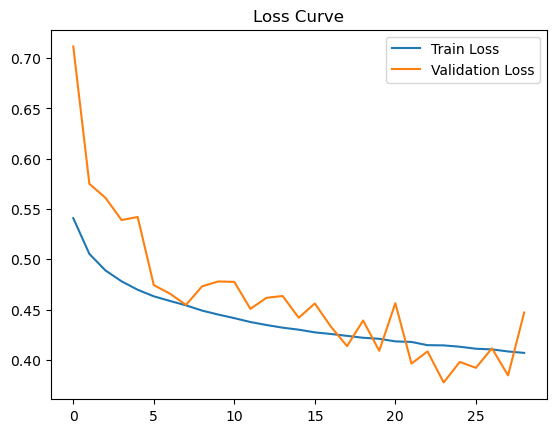

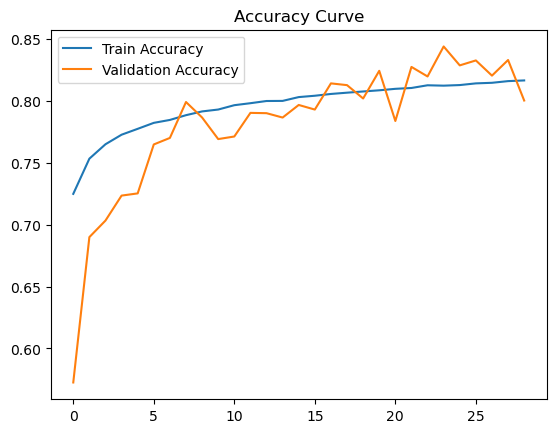

In [22]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy Curve")
plt.show()
